<a href="https://colab.research.google.com/github/jofmorenore/Spatial_Clustering/blob/main/Hierarchical_clustering_of_spatially_correlated_fd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración del entorno R en colab

In [ ]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
getwd()

[1] "/content"


In [4]:
%%R
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.3.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# “Canadian temperature” data (Ramsey & Silverman)

In [ ]:
%%R
library(dplyr)
library(ggplot2)

In [ ]:
%%R
if("geofd" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geofd"))}
library(geofd)

In [ ]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
library(sf)

In [9]:
%%R
mundoshp <- sf::st_read("/content/drive/MyDrive/Curso/admin00.shp",quiet=TRUE)
Canada <- mundoshp %>% 
            filter(CNTRY_NAME %in% c("Canada"))
str(Canada, max.level = 1)

Classes ‘sf’ and 'data.frame':	13 obs. of  13 variables:
 $ FIPS_ADMIN: chr  "CA13" "CA12" "CA05" "CA09" ...
 $ GMI_ADMIN : chr  "CAN-NTR" "CAN-YTR" "CAN-NWF" "CAN-PEI" ...
 $ ADMIN_NAME: chr  "Northwest Territories" "Yukon Territory" "Newfoundland" "Prince Edward Island" ...
 $ FIPS_CNTRY: chr  "CA" "CA" "CA" "CA" ...
 $ GMI_CNTRY : chr  "CAN" "CAN" "CAN" "CAN" ...
 $ CNTRY_NAME: chr  "Canada" "Canada" "Canada" "Canada" ...
 $ POP_ADMIN : int  27928 28927 591593 135042 936538 7176389 27500 1136345 2649068 1029142 ...
 $ TYPE_ENG  : chr  "Territory" "Territory" "Province" "Province" ...
 $ TYPE_LOC  : chr  "Territory" "Territory" "Province" "Province" ...
 $ SQKM      : num  1338703 481287 396928 5959 55051 ...
 $ SQMI      : num  516873 185825 153254 2301 21255 ...
 $ COLOR_MAP : chr  "1" "8" "11" "7" ...
 $ geometry  :sfc_MULTIPOLYGON of length 13; first list element: List of 25
  ..- attr(*, "class")= chr [1:3] "XY" "MULTIPOLYGON" "sfg"
 - attr(*, "sf_column")= chr "geometry"
 - att

In [10]:
%%R
data(CanadianWeather, package="fda")
str(CanadianWeather, max.level = 1)

List of 8
 $ dailyAv      : num [1:365, 1:35, 1:3] -3.6 -3.1 -3.4 -4.4 -2.9 -4.5 -5.5 -3.1 -4 -5 ...
  ..- attr(*, "dimnames")=List of 3
 $ place        : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ province     : Named chr [1:35] "Newfoundland" "Nova Scotia" "Nova Scotia" "Nova Scotia" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ coordinates  : num [1:35, 1:2] 47.3 44.4 46.1 43.5 42.5 ...
  ..- attr(*, "dimnames")=List of 2
 $ region       : Named chr [1:35] "Atlantic" "Atlantic" "Atlantic" "Atlantic" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ monthlyTemp  : num [1:12, 1:35] -4.65 -5.33 -2.53 1.26 5.79 ...
  ..- attr(*, "dimnames")=List of 2
 $ monthlyPrecip: num [1:12, 1:35] 4.65 4.74 4.24 3.62 3.25 ...
  ..- attr(*, "dimnames")=List of 2
 $ geogindex    : Named num [1:35] 24 9 25 34 4 8 22 1 2 19 ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...


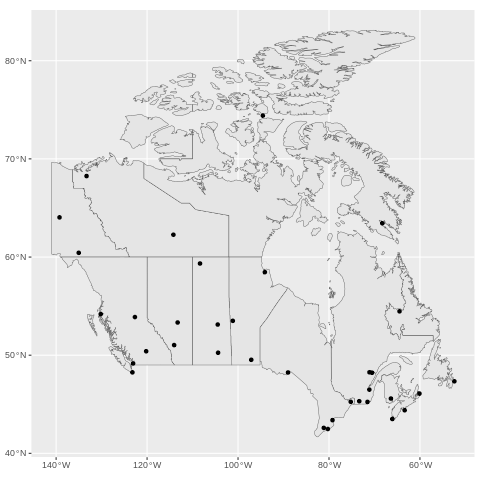

In [11]:
%%R
CanadianWeather.point = as.data.frame(CanadianWeather$coordinates) %>% mutate(W.longitude = - W.longitude) %>%
                          st_as_sf(coords = c("W.longitude", "N.latitude"), crs = 4326)

ggplot() + 
  geom_sf(data = Canada) +
  geom_sf(data = CanadianWeather.point, col = 'black') 

NULL


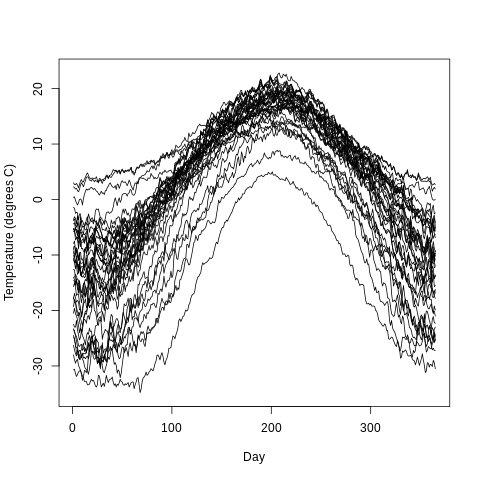

In [12]:
%%R
plot(CanadianWeather$dailyAv[,1,'Temperature.C'], type = 'l', ylab = 'Temperature (degrees C)', xlab = 'Day', ylim =c(-35,23))
apply(CanadianWeather$dailyAv[,-1,'Temperature.C'], 2, function(x) lines(x))

# Smooth the observed data using [geodf](https://cran.r-project.org/web/packages/geofd/geofd.pdf)

A Fourier basis with 65 functions is used to smooth the discrete temperature values observed at each weather station

[1] "done"


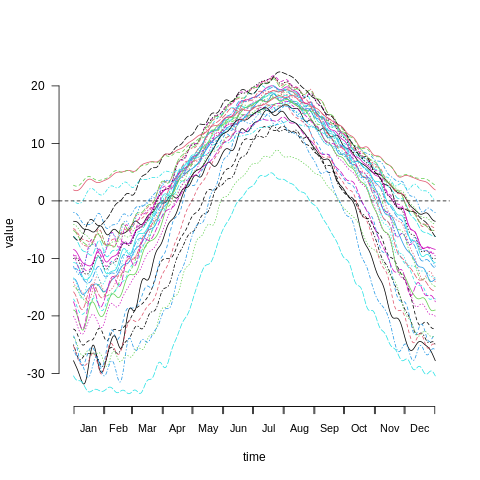

In [13]:
%%R
### functional response with vector explanatory variables
daybasis65 <- create.fourier.basis(rangeval=c(0, 365), nbasis=65, period = 365,
                                   axes=list('axesIntervals'))
Temp.fd <- with(CanadianWeather, smooth.basisPar(day.5,
                                                 dailyAv[,,'Temperature.C'], daybasis65)$fd)

plot(Temp.fd)

# Remove the spatial trend

Consider the functional linear model

$$ X_i(t) = \hat{\alpha}(t) + \hat{\alpha}_1(t) {Longitude}_i + \hat{\alpha}_2(t) {Latitude}_i + e_i(t) $$

In [14]:
%%R
CanadianWeather$coordinates = data.frame(CanadianWeather$coordinates) %>% mutate(W.longitude = - W.longitude)
TempRgn.f <- fRegress(Temp.fd ~ W.longitude + N.latitude, CanadianWeather$coordinates)
summary(TempRgn.f)

               Length Class  Mode   
yfdobj             3  fd     list   
xfdlist            3  -none- list   
betalist           3  -none- list   
betaestlist        3  -none- list   
yhatfdobj          3  fd     list   
Cmat           38025  -none- numeric
Dmat             195  -none- numeric
Cmatinv        38025  -none- numeric
wt                35  -none- numeric
df                 1  -none- logical
y2cMap             0  -none- NULL   
SigmaE             0  -none- NULL   
betastderrlist     0  -none- NULL   
bvar               0  -none- NULL   
c2bMap             0  -none- NULL   


In [52]:
%%R
fdobj.res = TempRgn.f$yfdobj-TempRgn.f$yhatfdobj
res.fd = smooth.fdPar(fdobj.res, Lfdobj=NULL, lambda=1e-4,estimate=TRUE, penmat=NULL)
res.fd2 = smooth.fdPar(fdobj.res, 
                       Lfdobj=vec2Lfd(c(0,(2*pi/diff(fdobj.res$basis$rangeval))^2,0), fdobj.res$basis$rangeval), 
                       lambda=1, estimate=TRUE, penmat=NULL)

In [53]:
%%R
jpeg("Fig2.jpg", width = 1600, height = 900)
par(mfrow=c(1,2))
plot(res.fd, lty=1, col=8,
     main="residual functions", xlab="Day", ylab="Temperature (Degrees C)")
plot(res.fd2, lty=1, col=8,
     main="Smoothed residual functions", xlab="Day", ylab="Temperature (Degrees C)")
dev.off()

png 
  2 


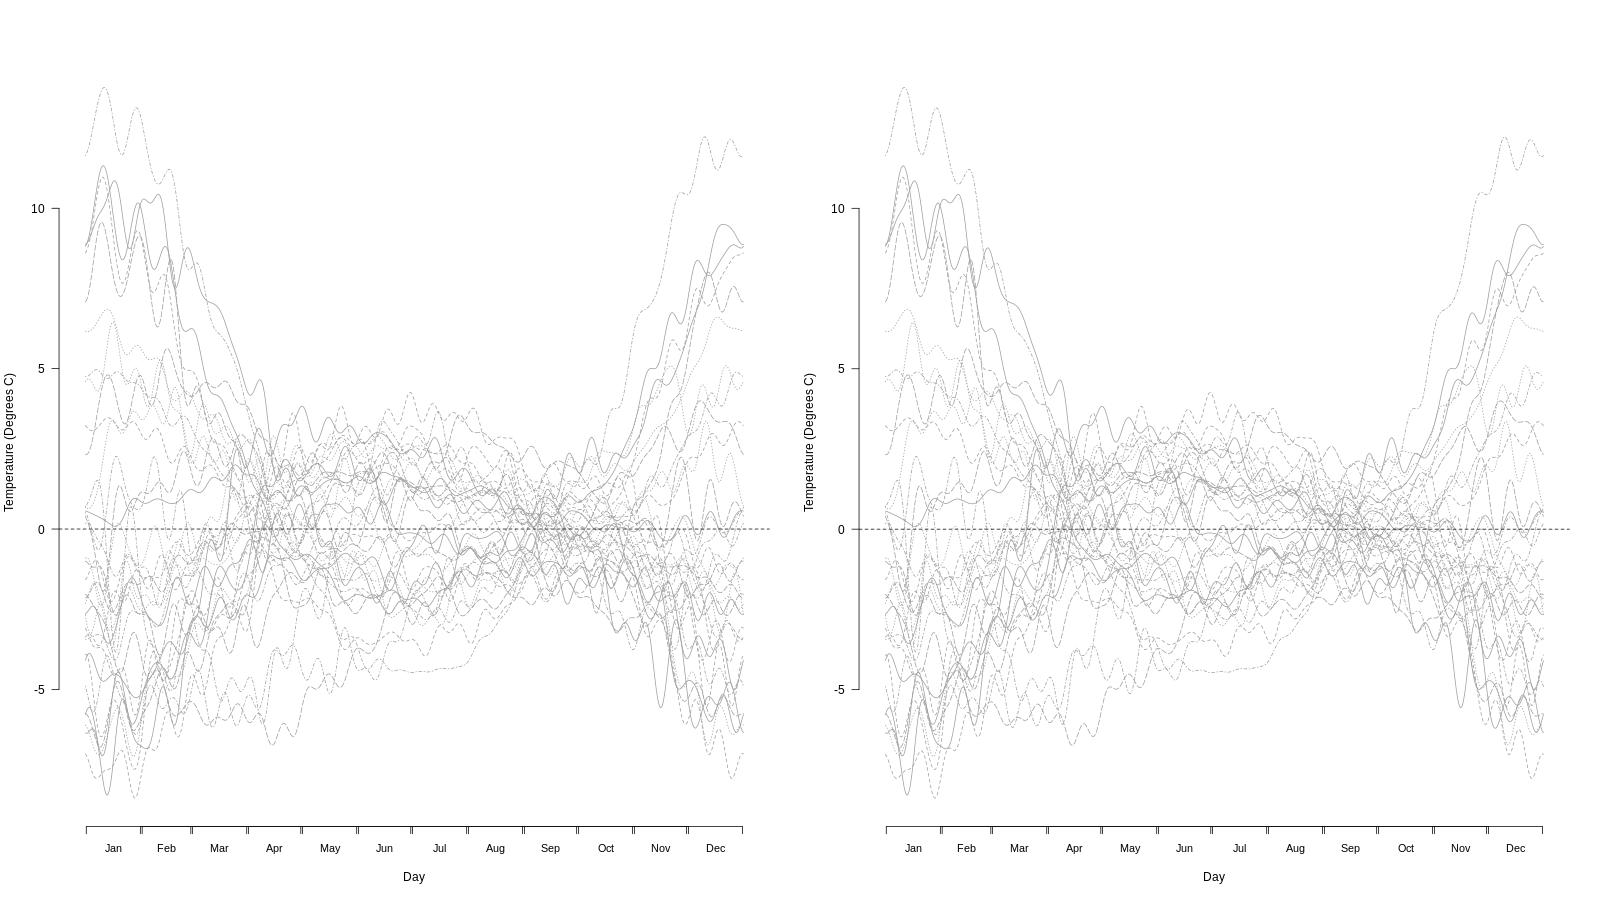

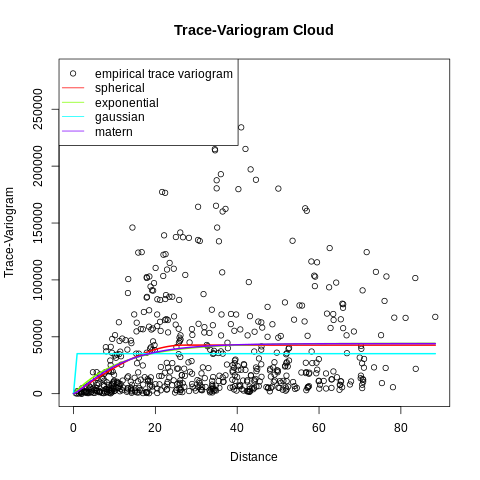

In [17]:
%%R
coord.cero <- matrix(c(-64.06, 45.79),nrow=1,ncol=2)
okfd.res<-okfd(new.coords=coord.cero, coords=CanadianWeather$coordinates,
               data=CanadianWeather$dailyAv[,,'Temperature.C'], smooth.type='fourier',nbasis=65, argvals=day.5, fix.nugget=TRUE,
               kappa=0.7)
plot(okfd.res)

In [18]:
%%R
str(fdobj.res)

List of 3
 $ coefs  : num [1:65, 1:35] 63.1 20.1 73.2 17 6.2 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:65] "const" "sin1" "cos1" "sin2" ...
  .. ..$ : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ basis  :List of 11
  ..$ call       : language basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params,      dropind = dropind, quadvals = qu| __truncated__
  ..$ type       : chr "fourier"
  ..$ rangeval   : num [1:2] 0 365
  ..$ nbasis     : num 65
  ..$ params     : num 365
  ..$ dropind    : num(0) 
  ..$ quadvals   : NULL
  ..$ values     : list()
  ..$ basisvalues: list()
  ..$ names      : chr [1:65] "const" "sin1" "cos1" "sin2" ...
  ..$ axes       :List of 1
  .. ..$ : chr "axesIntervals"
  ..- attr(*, "class")= chr "basisfd"
 $ fdnames:List of 3
  ..$ time  : chr [1:365] "jan01" "jan02" "jan03" "jan04" ...
  ..$ reps  : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
  ..$ values: chr "value"
 - attr(*, "class")= chr "fd"


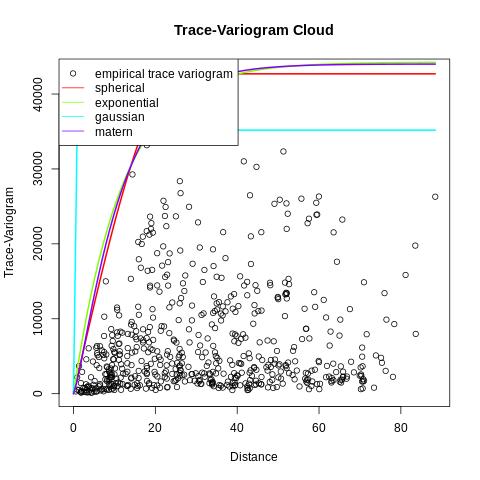

In [62]:
%%R
M <- fourierpen(fdobj.res$basis,  Lfdobj=0)
L2norm = l2.norm(ncol(fdobj.res$coefs), res.fd, M)

new.emp.trace.vari <- trace.variog(coords=CanadianWeather$coordinates,
                                   L2norm=L2norm, bin=FALSE)

okfd.res$emp.trace.vari <- new.emp.trace.vari
plot(okfd.res)

In [63]:
%%R
str(new.emp.trace.vari)

List of 6
 $ u          : num [1:595(1d)] 11.32 7.78 14.17 28.24 14.07 ...
 $ v          : num [1:595(1d)] 5217 1905 3816 24947 9225 ...
 $ output.type: chr "cloud"
 $ max.dist   : num 88.4
 $ Eu.d       : num [1:35, 1:35] 0 11.32 7.78 14.17 28.24 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
  .. ..$ : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ L2norm     : num [1:35, 1:35] 0 5217 1905 3816 24947 ...
 - attr(*, "class")= chr "variogram"


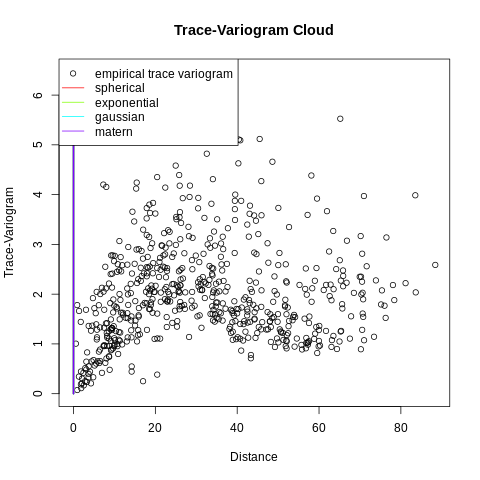

In [64]:
%%R
M2 <- fourierpen(fdobj.res$basis,  Lfdobj=int2Lfd(2))
L2norm2 = l2.norm(ncol(fdobj.res$coefs), res.fd, M2)

new.emp.trace.vari2 <- trace.variog(coords=CanadianWeather$coordinates,
                                   L2norm=L2norm2, bin=FALSE)

okfd.res$emp.trace.vari <- new.emp.trace.vari2
plot(okfd.res)

In [65]:
%%R
str(new.emp.trace.vari2)

List of 6
 $ u          : num [1:595(1d)] 11.32 7.78 14.17 28.24 14.07 ...
 $ v          : num [1:595(1d)] 1.065 0.619 1.132 1.139 1.47 ...
 $ output.type: chr "cloud"
 $ max.dist   : num 88.4
 $ Eu.d       : num [1:35, 1:35] 0 11.32 7.78 14.17 28.24 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
  .. ..$ : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ L2norm     : num [1:35, 1:35] 0 1.065 0.619 1.132 1.139 ...
 - attr(*, "class")= chr "variogram"


In [21]:
%%R
fit = fit.tracevariog(new.emp.trace.vari, models = "spherical", sigma2.0 = 7800, phi.0 =22,
                      fix.nugget=TRUE, fix.kappa=FALSE, max.dist.variogram=NULL)

str(fit)

List of 2
 $ best  :List of 16
  ..$ nugget               : num 0
  ..$ cov.pars             : num [1:2] 8090.9 22.1
  ..$ cov.model            : chr "spherical"
  ..$ kappa                : num 1
  ..$ value                : num 3.1e+10
  ..$ trend                : NULL
  ..$ beta.ols             : NULL
  ..$ practicalRange       : num 22.1
  ..$ max.dist             : num 88.4
  ..$ minimisation.function: chr "optim"
  ..$ weights              : chr "equal"
  ..$ method               : chr "OLS"
  ..$ fix.nugget           : logi TRUE
  ..$ fix.kappa            : logi FALSE
  ..$ message              : chr "optim convergence code: 0"
  ..$ call                 : language .variofit(vario = emp.trace.vari, ini.cov.pars = c(sigma2.0, phi.0), cov.model = models[cont],      fix.nugget = | __truncated__ ...
  ..- attr(*, "class")= chr [1:2] "variomodel" "variofit"
 $ fitted:List of 1
  ..$ :List of 16
  .. ..$ nugget               : num 0
  .. ..$ cov.pars             : num [1:2] 8090.9 22.

In [66]:
%%R
fit = fit.tracevariog(new.emp.trace.vari2, models = "spherical", sigma2.0 = 7800, phi.0 =22,
                      fix.nugget=TRUE, fix.kappa=FALSE, max.dist.variogram=NULL)

str(fit)

List of 2
 $ best  :List of 16
  ..$ nugget               : num 0
  ..$ cov.pars             : num [1:2] 184 5804
  ..$ cov.model            : chr "spherical"
  ..$ kappa                : num 1
  ..$ value                : num 1135
  ..$ trend                : NULL
  ..$ beta.ols             : NULL
  ..$ practicalRange       : num 5804
  ..$ max.dist             : num 88.4
  ..$ minimisation.function: chr "optim"
  ..$ weights              : chr "equal"
  ..$ method               : chr "OLS"
  ..$ fix.nugget           : logi TRUE
  ..$ fix.kappa            : logi FALSE
  ..$ message              : chr "optim convergence code: 0"
  ..$ call                 : language .variofit(vario = emp.trace.vari, ini.cov.pars = c(sigma2.0, phi.0), cov.model = models[cont],      fix.nugget = | __truncated__ ...
  ..- attr(*, "class")= chr [1:2] "variomodel" "variofit"
 $ fitted:List of 1
  ..$ :List of 16
  .. ..$ nugget               : num 0
  .. ..$ cov.pars             : num [1:2] 184 5804
  .. ..

# [Clustering the “Canadian temperature” data (Ramsey & Silverman): multivariate case](https://rpubs.com/stat17_hb/functional_data_clustering)

In [22]:
%%R
basis <- create.fourier.basis(c(0, 365), nbasis=21, period=365) 

daytempfd <- smooth.basis(day.5, CanadianWeather$dailyAv[,,"Temperature.C"], basis,
                          fdnames=list("Day", "Station", "Deg C"))$fd

dayprecfd <- smooth.basis(day.5, CanadianWeather$dailyAv[,,"Precipitation.mm"], basis,
                        fdnames=list("Day", "Station", "Mm"))$fd

In [ ]:
%%R
remotes::install_github("cran/funHDDC")
library(funHDDC)

In [24]:
%%R
res.multi <- funHDDC(list(daytempfd,dayprecfd), K=4)

      model K threshold complexity       BIC
1 AKJBKQKDK 4       0.2        505 -8,189.95

SELECTED: model  AKJBKQKDK  with  4  clusters.
Selection Criterion: BIC.


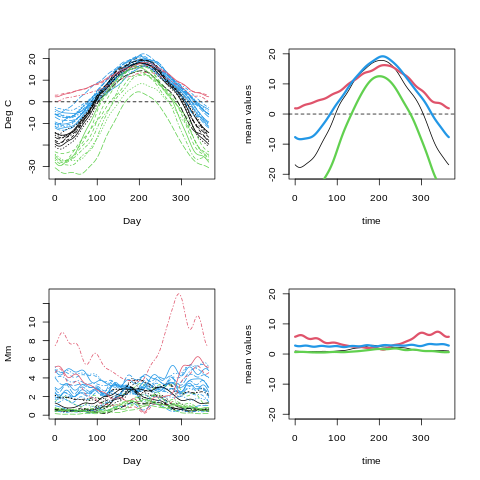

In [25]:
%%R
## Graphical representation of groups mean curves
par(mfrow=c(2,2))

## Temperature
plot(daytempfd, col=res.multi$class, lwd=2, lty=1)
select1 <- fd(daytempfd$coefs[,which(res.multi$class==1)], daytempfd$basis)
select2 <- fd(daytempfd$coefs[,which(res.multi$class==2)], daytempfd$basis)
select3 <- fd(daytempfd$coefs[,which(res.multi$class==3)], daytempfd$basis)
select4 <- fd(daytempfd$coefs[,which(res.multi$class==4)], daytempfd$basis)

plot(mean.fd(select1),col=1, ylim=c(-20,20), lty=1, lwd=3)
lines(mean.fd(select2),col=2, lty=1,lwd=3)
lines(mean.fd(select3),col=3, lty=1,lwd=3)
lines(mean.fd(select4),col=4, lty=1,lwd=3)

## Precipitation
plot(dayprecfd, col=res.multi$class, lwd=2, lty=1)

select1b <- fd(dayprecfd$coefs[,which(res.multi$class==1)], dayprecfd$basis)
select2b <- fd(dayprecfd$coefs[,which(res.multi$class==2)], dayprecfd$basis)
select3b <- fd(dayprecfd$coefs[,which(res.multi$class==3)], dayprecfd$basis)
select4b <- fd(dayprecfd$coefs[,which(res.multi$class==4)], dayprecfd$basis)

plot(mean.fd(select1b),col=1, ylim=c(-20,20), lty=1, lwd=3)
lines(mean.fd(select2b),col=2, lty=1,lwd=3)
lines(mean.fd(select3b),col=3, lty=1,lwd=3)
lines(mean.fd(select4b),col=4, lty=1,lwd=3)

In [26]:
%%R
colnames(daytempfd$coefs[,which(res.multi$class==1)])

[1] "Arvida"      "Bagottville" "Thunder Bay" "Winnipeg"    "The Pas"    
[6] "Regina"      "Pr. Albert"  "Edmonton"    "Whitehorse" 


In [27]:
%%R
CanadianWeather$place

 [1] "St. Johns"    "Halifax"      "Sydney"       "Yarmouth"     "Charlottvl"  
 [6] "Fredericton"  "Scheffervll"  "Arvida"       "Bagottville"  "Quebec"      
[11] "Sherbrooke"   "Montreal"     "Ottawa"       "Toronto"      "London"      
[16] "Thunder Bay"  "Winnipeg"     "The Pas"      "Churchill"    "Regina"      
[21] "Pr. Albert"   "Uranium City" "Edmonton"     "Calgary"      "Kamloops"    
[26] "Vancouver"    "Victoria"     "Pr. George"   "Pr. Rupert"   "Whitehorse"  
[31] "Dawson"       "Yellowknife"  "Iqaluit"      "Inuvik"       "Resolute"    


In [28]:
%%R
data.frame(list("place"=colnames(daytempfd$coefs), "class"=res.multi$class)) %>% filter(class ==1)

        place class
1      Arvida     1
2 Bagottville     1
3 Thunder Bay     1
4    Winnipeg     1
5     The Pas     1
6      Regina     1
7  Pr. Albert     1
8    Edmonton     1
9  Whitehorse     1


In [29]:
%%R
head(CanadianWeather.point)

Simple feature collection with 6 features and 0 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -80.25 ymin: 42.48 xmax: -52.43 ymax: 47.34
Geodetic CRS:  WGS 84
              geometry
1 POINT (-52.43 47.34)
2 POINT (-63.36 44.39)
3 POINT (-60.11 46.09)
4  POINT (-66.07 43.5)
5 POINT (-80.25 42.48)
6 POINT (-66.39 45.58)


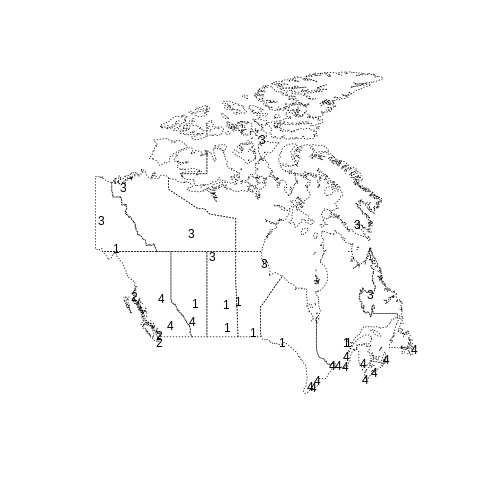

In [30]:
%%R
plot(Canada$geometry, lty = 3)
plot(CanadianWeather.point, pch = as.character(res.multi$class), add = TRUE)

# [TerraClimate](https://doi.org/10.1038/sdata.2017.191)

In [ ]:
%%R
remotes::install_github("mikejohnson51/climateR")
library(climateR)

In [32]:
%%R
id = "terraclim"
filter(climateR::params, id == !!id) %>% dplyr::select(variable, units, duration, interval,nT,description,URL)

   variable    units              duration interval  nT
1       aet       mm 1958-01-01/2021-12-01 1 months 768
2       def       mm 1958-01-01/2021-12-01 1 months 768
3      PDSI unitless 1958-01-01/2021-12-01 1 months 768
4       pet       mm 1958-01-01/2021-12-01 1 months 768
5       ppt       mm 1958-01-01/2021-12-01 1 months 768
6         q       mm 1958-01-01/2021-12-01 1 months 768
7      soil       mm 1958-01-01/2021-12-01 1 months 768
8      tmax     degC 1958-01-01/2021-12-01 1 months 768
9      tmin     degC 1958-01-01/2021-12-01 1 months 768
10      vap      kPa 1958-01-01/2021-12-01 1 months 768
11      vpd      kPa 1958-01-01/2021-12-01 1 months 768
12       ws      m/s 1958-01-01/2021-12-01 1 months 768
                                                         description
1                                           water_evaporation_amount
2  water_potential_evaporation_amount_minus_water_evaporation_amount
3                                      palmer_drought_severity_in